In [1]:
from css_utility import *

/home/lee/anaconda3/lib/python3.8/site-packages/scipy/__init__.py:138: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5)
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion} is required for this version of "


Is the enhancers in genic regions are always labelled as genic enhancer?
* "F": genic enhancer
* "G": ehnacer

In [2]:
with open("../database/temp_files/whole_gene_unit/E003_css_gene_unit_lst_all.pkl", 'rb') as file:
    data = pickle.load(file)

In [3]:
all_genes_in_cell=flatLst(data)
genic_enh_in_gene=[item for item in all_genes_in_cell if "F" in item]
enh_in_gene=[item for item in all_genes_in_cell if "G" in item]
two_enh_in_gene=[item for item in all_genes_in_cell if "G" in item and "F" in item]

In [4]:
len(genic_enh_in_gene)

6454

In [6]:
len(enh_in_gene)

26455

In [7]:
len(two_enh_in_gene)

4483

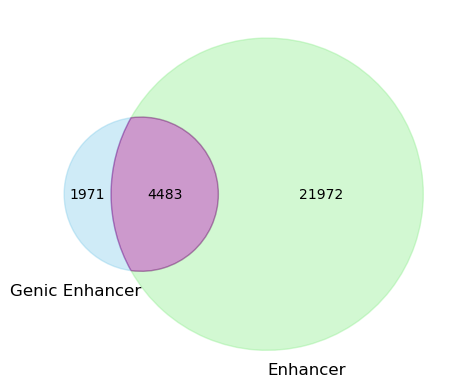

In [54]:
import matplotlib.pyplot as plt
from matplotlib_venn import venn2

# Define the sizes of the sets
set1_size = len(genic_enh_in_gene)-len(two_enh_in_gene)
set2_size = len(enh_in_gene)-len(two_enh_in_gene)
intersection_size = len(two_enh_in_gene)

# Create the Venn diagram
venn = venn2(subsets=(set1_size, set2_size, intersection_size),
             set_labels=('Genic Enhancer', 'Enhancer', 'Enhancer and Genic Enhancer'))

# Change the colors of each section
venn.get_patch_by_id('10').set_color('skyblue')  # Change color of genic_enh set
venn.get_patch_by_id('01').set_color('lightgreen')  # Change color of enh set
venn.get_patch_by_id('11').set_color('purple')  # Change color of intersection

In [36]:
len_genic_enh_in_gene=[len(item) for item in genic_enh_in_gene]
len_enh_in_gene=[len(item) for item in enh_in_gene]
len_two_enh_in_gene=[len(item)for item in two_enh_in_gene]

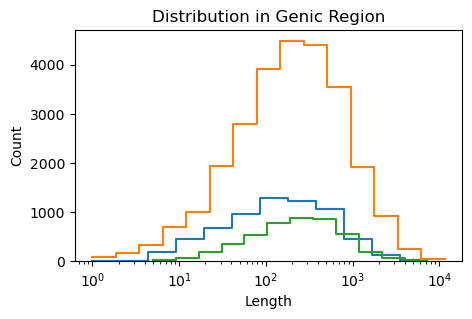

In [59]:
fig=plt.figure(figsize=(5,3))
sns.histplot(len_genic_enh_in_gene,fill=False, element="step",bins=12, log_scale=True, legend="Genic Enhancer")
sns.histplot(len_enh_in_gene,fill=False, element="step",bins=15, log_scale=True, legend="Enhancer")
sns.histplot(len_two_enh_in_gene,fill=False, element="step",bins=12, log_scale=True, legend="Genic Enhancer and Enhancer")

plt.xlabel('Length')
plt.ylabel('Count')
plt.title('Distribution in Genic Region')

plt.show()



In [67]:
test_path=[
    "../database/temp_files/whole_gene_unit/E003_css_gene_unit_lst_all.pkl",
    "../database/temp_files/whole_gene_unit/E004_css_gene_unit_lst_all.pkl",
    "../database/temp_files/whole_gene_unit/E006_css_gene_unit_lst_all.pkl",
    "../database/temp_files/whole_gene_unit/E011_css_gene_unit_lst_all.pkl",
    "../database/temp_files/whole_gene_unit/E016_css_gene_unit_lst_all.pkl",
    "../database/temp_files/whole_gene_unit/E027_css_gene_unit_lst_all.pkl",
    "../database/temp_files/whole_gene_unit/E037_css_gene_unit_lst_all.pkl",
    "../database/temp_files/whole_gene_unit/E050_css_gene_unit_lst_all.pkl",
    "../database/temp_files/whole_gene_unit/E066_css_gene_unit_lst_all.pkl",
    "../database/temp_files/whole_gene_unit/E096_css_gene_unit_lst_all.pkl",
]

In [143]:
def countEnhByCell(path):
    dir_lst=os.listdir(path)
    gene_lst=sorted([item for item in dir_lst if ".pkl" in item])
    file_path=[os.path.join(path,item) for item in gene_lst]

    gen_enh_pro_all=[]
    enh_pro_all=[]
    gen_both_pro_all=[]
    
    for i, file in enumerate(file_path):
        with open(file, 'rb') as f:
            gene_css = pickle.load(f)
            
        all_genes_in_cell=flatLst(gene_css)
        enh_in_gene=[item for item in all_genes_in_cell if "G" in item]
        genic_enh_in_gene=[item for item in all_genes_in_cell if "F" in item]
        two_enh_in_gene=[item for item in all_genes_in_cell if "G" in item and "F" in item]
        
        tot_num=len(genic_enh_in_gene)+len(enh_in_gene)
        
        enh_pro=len(enh_in_gene)/tot_num
        enh_pro_all.append(enh_pro)
        
        gen_enh_pro=len(genic_enh_in_gene)/tot_num
        gen_enh_pro_all.append(gen_enh_pro)

        gen_both_pro=len(two_enh_in_gene)/tot_num
        gen_both_pro_all.append(gen_both_pro)
        
    fig = plt.figure(figsize=(6, 3))  # Adjust the figure size as per your requirements

    # Plotting the first bar plot
    ax1 = fig.add_subplot(1, 3, 1)
    sns.violinplot(data=enh_pro_all, ax=ax1, color="cornflowerblue")
#     sns.barplot(data=enh_pro_all, ax=ax1, width=0.5, color="cornflowerblue")  
    ax1.set_ylabel('Proportion')
    ax1.set_title('Enhancer')
    ax1.set_ylim(-0.1, 1.1)

    # Plotting the second bar plot
    ax2 = fig.add_subplot(1, 3, 2)
    sns.violinplot(data=gen_enh_pro_all, ax=ax2,color="darkorange" )  
#     sns.barplot(data=gen_enh_pro_all, ax=ax2,width=0.5 ,color="darkorange" )  
    ax2.set_title('Genic Enhancer')
    ax2.set_ylim(-0.1, 1.1)

    # Plotting the third bar plot
    ax3 = fig.add_subplot(1, 3, 3)
    sns.violinplot(data=gen_both_pro_all, ax=ax3,color="teal")
#     sns.barplot(data=gen_both_pro_all, ax=ax3, width=0.5,color="teal")  
    ax3.set_ylabel('Proportion')
    ax3.set_title('Both')
    ax3.set_ylim(-0.1, 1.1)

    plt.tight_layout()  # Adjust the spacing between subplots

    plt.show()
    return enh_pro_all,gen_enh_pro_all,gen_both_pro_all

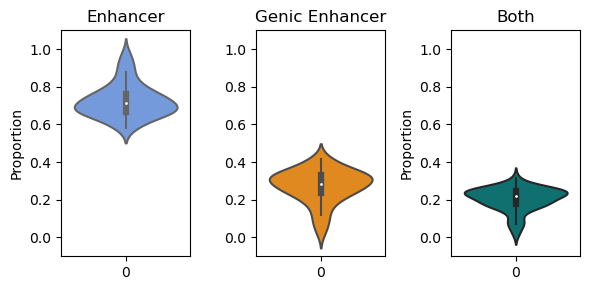

In [144]:
enh_pro_all,gen_enh_pro_all,gen_both_pro_all=countEnhByCell("../database/temp_files/whole_gene_unit/")